In [0]:
import math
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import Callback

In [0]:
class TrainingProgressCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print("Epoch {} Completed!".format(epoch))

In [0]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [0]:
# read dataset from file
df = pd.read_excel("./Data Science_20200214.xlsx", index_col="Date", parse_dates=True)
df = df.sort_index(ascending=True)
df = df[["Shipment","Order","Revenue"]]

In [0]:
# normalize data into 0 to 1 using MinMaxScaler
scaler = MinMaxScaler()

df_transformed = scaler.fit_transform(df)

joblib.dump(scaler, './default_scaler.pkl')

['./default_scaler.pkl']

In [0]:
# choose a number of time steps
n_epochs, n_neurons = 1000, 300
n_steps_in, n_steps_out = 120, 90
n_features = df.columns.size

# split into samples
X, y = split_sequence(df_transformed, n_steps_in, n_steps_out)

# reshape from [samples, timesteps] into [samples, timesteps, features]

X = X.reshape((X.shape[0], n_steps_in, n_features))
y = y.reshape((y.shape[0], n_steps_in, n_features))

In [0]:
# define model
model = Sequential()
model.add((LSTM(n_neurons, activation='tanh', input_shape=(n_steps_in, n_features))))
model.add(RepeatVector(n_steps_out))
model.add((LSTM(n_neurons, activation='tanh', return_sequences=True)))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X[:-1], y[:-1], epochs=n_epochs, verbose=1, callbacks=[TrainingProgressCallback()])

model.save('default_model.h5')

Epoch 1/300
20/20 [==============================] - 1s 27ms/step - loss: 0.1348
Epoch 2/300
20/20 [==============================] - 0s 24ms/step - loss: 0.0893
Epoch 3/300
20/20 [==============================] - 0s 24ms/step - loss: 0.0826
Epoch 4/300
20/20 [==============================] - 0s 24ms/step - loss: 0.0810
Epoch 5/300
20/20 [==============================] - 0s 24ms/step - loss: 0.0794
Epoch 6/300
20/20 [==============================] - 0s 24ms/step - loss: 0.0800
Epoch 7/300
20/20 [==============================] - 0s 24ms/step - loss: 0.0800
Epoch 8/300
20/20 [==============================] - 0s 24ms/step - loss: 0.0718
Epoch 9/300
20/20 [==============================] - 0s 24ms/step - loss: 0.0591
Epoch 10/300
20/20 [==============================] - 0s 24ms/step - loss: 0.0457
Epoch 11/300
20/20 [==============================] - 0s 24ms/step - loss: 0.0433
Epoch 12/300
20/20 [==============================] - 0s 24ms/step - loss: 0.0302
Epoch 13/300
20/20 [=====

Test Score: 16.99 RMSE
Final Revenue Error: 2.61%


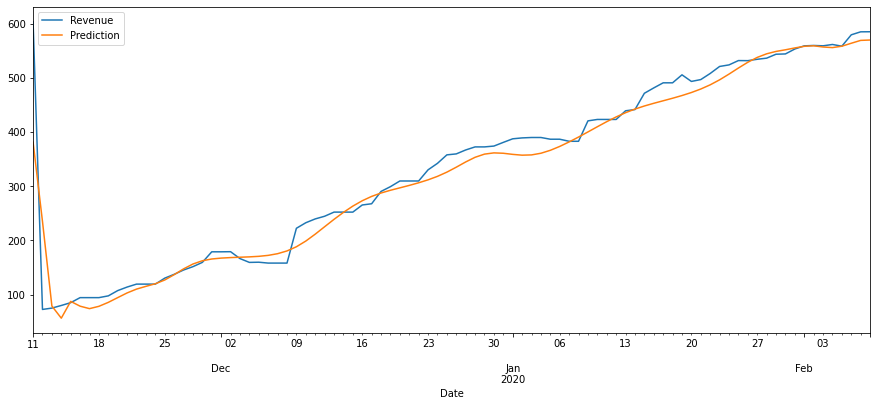

In [0]:
#validate_X = df_transformed[-(n_steps_in):].reshape((1,n_steps_in, n_features))
validate_X = X[-1].reshape(1, n_steps_in, n_features)
validate_Y = model.predict(validate_X)
validate_Y = scaler.inverse_transform(validate_Y[0])

df_validate = df.copy()
df_validate = df_validate[-(n_steps_out):]
df_validate["Prediction"] = validate_Y[:,n_features-1]
df_validate[["Revenue","Prediction"]].plot(figsize=(15,6))

validateScore = math.sqrt(mean_squared_error(df_validate["Revenue"].iloc[3:], df_validate["Prediction"].iloc[3:]))
print('Test Score: %.2f RMSE' % (validateScore))

Final_Revenue_Validate_Error = 100*(df_validate["Revenue"].iloc[3:].max() - df_validate["Prediction"].iloc[3:].max())/ df_validate["Revenue"].iloc[3:].max()
print('Final Revenue Error: %.2f%%' % (Final_Revenue_Validate_Error))

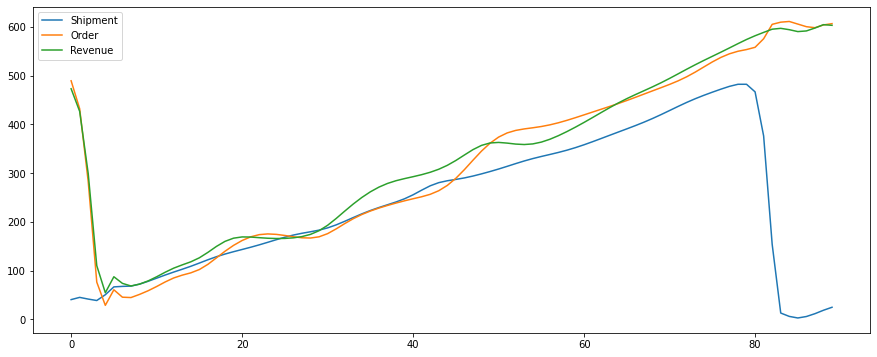

In [0]:
df_future_pred = df.copy()

df_future_pred = df_future_pred[["Shipment","Order","Revenue"]].iloc[-n_steps_in:]
df_future_pred_transformed = scaler.transform(df_future_pred[-n_steps_in:])
df_future_pred_transformed = df_future_pred_transformed.reshape((1,n_steps_in, n_features))

future_Y = model.predict(df_future_pred_transformed)
future_Y = scaler.inverse_transform(future_Y[0])

df_future = pd.DataFrame(future_Y,columns=["Shipment","Order","Revenue"])
df_future.plot(figsize=(15,6))

In [0]:
df_future['Revenue'].max()

604.3209228515625

In [0]:
df_future_pred

,Shipment,Order,Revenue
Date,,,
2019-10-12,360.369822,440.932365,416.545608
2019-10-13,363.234093,440.932365,416.545608
2019-10-14,374.125462,452.180671,439.025024
2019-10-15,382.948701,457.802784,449.578740
2019-10-16,393.647869,470.975910,457.311454
...,...,...,...
2020-02-04,13.242820,618.009884,561.627466
2020-02-05,20.289526,617.782319,558.500053
2020-02-06,30.486240,617.782319,579.481675
